# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_66672/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_66672/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_66672/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2, "sigma_b": 10,        #Ignored not used
    "RW2": { "tau_a": 2, "tau_b": 1.0 },# mean τ² = 0.2 (keep marginals ~identity)
    "RW1": { "tau_a": 10,"tau_b": 15 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10 (weak)
    "RW1": { "tau_a": 2, "tau_b": 0.3 },# mean τ₁² = 0.3 (strong pull-to-linear)
    "RW2": { "tau_a": 2, "tau_b": 1.0 } # mean τ₂² = 1.0 (moderate curvature smoothing)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    inference = 'bayesian',
    device="cpu",
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

150


In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4135  val=236.7893  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:00<05:37,  2.95it/s]

[2/1000] train=228.9769  val=234.5872  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:01<05:37,  2.96it/s]

[3/1000] train=227.0675  val=232.3871  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:01<05:58,  2.77it/s]

[4/1000] train=223.5340  val=230.1882  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:01<06:41,  2.48it/s]

[5/1000] train=222.9343  val=227.9909  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:02<07:48,  2.12it/s]

[6/1000] train=230.9040  val=225.7943  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:02<07:44,  2.14it/s]

[7/1000] train=217.7485  val=223.5984  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:05<16:59,  1.03s/it]

[8/1000] train=220.4549  val=221.4040  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:07<23:12,  1.41s/it]

[9/1000] train=216.8664  val=219.2112  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:08<19:18,  1.17s/it]

[10/1000] train=215.3596  val=217.0196  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:08<16:00,  1.03it/s]

[11/1000] train=219.0622  val=214.8288  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:09<15:26,  1.07it/s]

[12/1000] train=216.3720  val=212.6394  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:10<13:40,  1.20it/s]

[13/1000] train=217.2487  val=210.4511  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0604


  1%|▏         | 14/1000 [00:10<12:31,  1.31it/s]

[14/1000] train=220.5367  val=208.2635  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:11<12:24,  1.32it/s]

[15/1000] train=207.6908  val=206.0775  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:11<11:15,  1.46it/s]

[16/1000] train=207.4634  val=203.8930  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  2%|▏         | 17/1000 [00:12<09:58,  1.64it/s]

[17/1000] train=200.5258  val=201.7099  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0641  σmax=0.0641


  2%|▏         | 18/1000 [00:12<09:25,  1.74it/s]

[18/1000] train=203.9188  val=199.5279  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:13<08:08,  2.01it/s]

[19/1000] train=195.0700  val=197.3469  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0660  σmax=0.0660


  2%|▏         | 20/1000 [00:13<07:41,  2.12it/s]

[20/1000] train=201.3604  val=195.1671  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:13<07:11,  2.27it/s]

[21/1000] train=188.1567  val=192.9881  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:14<06:53,  2.37it/s]

[22/1000] train=193.8430  val=190.8105  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0689  σmax=0.0689


  2%|▏         | 23/1000 [00:14<07:23,  2.20it/s]

[23/1000] train=184.2863  val=188.6345  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0699  σmax=0.0699


  2%|▏         | 24/1000 [00:15<08:20,  1.95it/s]

[24/1000] train=193.3595  val=186.4601  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:15<08:15,  1.97it/s]

[25/1000] train=184.2289  val=184.2868  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:16<08:57,  1.81it/s]

[26/1000] train=180.6128  val=182.1143  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0730  σmax=0.0730


  3%|▎         | 27/1000 [00:17<08:57,  1.81it/s]

[27/1000] train=180.3566  val=179.9428  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0741  σmax=0.0741


  3%|▎         | 28/1000 [00:17<08:39,  1.87it/s]

[28/1000] train=178.1867  val=177.7722  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  3%|▎         | 29/1000 [00:18<08:42,  1.86it/s]

[29/1000] train=171.3963  val=175.6034  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0762  σmax=0.0762


  3%|▎         | 30/1000 [00:18<08:46,  1.84it/s]

[30/1000] train=180.1299  val=173.4363  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0773  σmax=0.0773


  3%|▎         | 31/1000 [00:19<08:09,  1.98it/s]

[31/1000] train=173.2089  val=171.2703  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0785  σmax=0.0785


  3%|▎         | 32/1000 [00:19<07:23,  2.18it/s]

[32/1000] train=172.1634  val=169.1048  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  3%|▎         | 33/1000 [00:19<07:08,  2.25it/s]

[33/1000] train=166.9370  val=166.9402  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0808  σmax=0.0808


  3%|▎         | 34/1000 [00:20<06:42,  2.40it/s]

[34/1000] train=164.6522  val=164.7774  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0819  σmax=0.0819


  4%|▎         | 35/1000 [00:20<06:31,  2.46it/s]

[35/1000] train=164.4707  val=162.6160  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0831  σmax=0.0831


  4%|▎         | 36/1000 [00:21<06:14,  2.57it/s]

[36/1000] train=162.3789  val=160.4560  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  4%|▎         | 37/1000 [00:21<07:13,  2.22it/s]

[37/1000] train=158.9170  val=158.2974  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0855  σmax=0.0856


  4%|▍         | 38/1000 [00:22<07:24,  2.16it/s]

[38/1000] train=151.6584  val=156.1404  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0868  σmax=0.0868


  4%|▍         | 39/1000 [00:22<07:16,  2.20it/s]

[39/1000] train=154.2820  val=153.9849  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0880  σmax=0.0880


  4%|▍         | 40/1000 [00:22<06:46,  2.36it/s]

[40/1000] train=153.7836  val=151.8305  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  4%|▍         | 41/1000 [00:23<06:58,  2.29it/s]

[41/1000] train=154.8701  val=149.6776  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0906  σmax=0.0906


  4%|▍         | 42/1000 [00:23<06:55,  2.30it/s]

[42/1000] train=154.7713  val=147.5262  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0919  σmax=0.0919


  4%|▍         | 43/1000 [00:24<06:30,  2.45it/s]

[43/1000] train=145.1889  val=145.3768  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0932  σmax=0.0932


  4%|▍         | 44/1000 [00:24<06:24,  2.49it/s]

[44/1000] train=138.5124  val=143.2292  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  4%|▍         | 45/1000 [00:24<06:05,  2.61it/s]

[45/1000] train=143.3999  val=141.0837  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0959  σmax=0.0960


  5%|▍         | 46/1000 [00:25<06:06,  2.60it/s]

[46/1000] train=141.6673  val=138.9400  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0973  σmax=0.0973


  5%|▍         | 47/1000 [00:25<06:12,  2.56it/s]

[47/1000] train=137.5316  val=136.7987  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0987  σmax=0.0987


  5%|▍         | 48/1000 [00:26<06:09,  2.58it/s]

[48/1000] train=135.8284  val=134.6576  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  5%|▍         | 49/1000 [00:26<05:50,  2.72it/s]

[49/1000] train=134.3471  val=132.5171  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1015  σmax=0.1016


  5%|▌         | 50/1000 [00:26<05:54,  2.68it/s]

[50/1000] train=132.8887  val=130.3769  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1030  σmax=0.1031


  5%|▌         | 51/1000 [00:27<06:41,  2.36it/s]

[51/1000] train=130.9390  val=128.2376  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1045  σmax=0.1045


  5%|▌         | 52/1000 [00:27<07:02,  2.24it/s]

[52/1000] train=125.4850  val=126.0997  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  5%|▌         | 53/1000 [00:28<07:42,  2.05it/s]

[53/1000] train=124.8460  val=123.9646  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1075  σmax=0.1076


  5%|▌         | 54/1000 [00:28<07:39,  2.06it/s]

[54/1000] train=121.8714  val=121.8314  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1090  σmax=0.1091


  6%|▌         | 55/1000 [00:29<07:54,  1.99it/s]

[55/1000] train=124.5637  val=119.7002  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1106  σmax=0.1107


  6%|▌         | 56/1000 [00:29<08:06,  1.94it/s]

[56/1000] train=114.7681  val=117.5712  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1121  σmax=0.1122


  6%|▌         | 57/1000 [00:30<09:29,  1.66it/s]

[57/1000] train=114.2793  val=115.4438  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1137  σmax=0.1138


  6%|▌         | 58/1000 [00:31<09:27,  1.66it/s]

[58/1000] train=115.6339  val=113.3181  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1155  σmin=0.1154  σmax=0.1155


  6%|▌         | 59/1000 [00:31<09:06,  1.72it/s]

[59/1000] train=113.0385  val=111.1943  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1170  σmax=0.1171


  6%|▌         | 60/1000 [00:32<08:57,  1.75it/s]

[60/1000] train=110.4144  val=109.0724  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  6%|▌         | 61/1000 [00:32<08:42,  1.80it/s]

[61/1000] train=105.8825  val=106.9523  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1205  σmin=0.1204  σmax=0.1205


  6%|▌         | 62/1000 [00:33<08:24,  1.86it/s]

[62/1000] train=105.8729  val=104.8341  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1221  σmax=0.1222


  6%|▋         | 63/1000 [00:34<09:04,  1.72it/s]

[63/1000] train=103.7624  val=102.7176  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1238  σmax=0.1239


  6%|▋         | 64/1000 [00:34<09:12,  1.69it/s]

[64/1000] train=103.1358  val=100.6028  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1255  σmax=0.1257


  6%|▋         | 65/1000 [00:35<09:33,  1.63it/s]

[65/1000] train=101.3833  val=98.4897  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1275  σmin=0.1273  σmax=0.1275


  7%|▋         | 66/1000 [00:36<09:40,  1.61it/s]

[66/1000] train=98.4252  val=96.3784  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1293  σmin=0.1291  σmax=0.1293


  7%|▋         | 67/1000 [00:36<09:37,  1.62it/s]

[67/1000] train=96.8525  val=94.2694  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1309  σmax=0.1311


  7%|▋         | 68/1000 [00:37<09:39,  1.61it/s]

[68/1000] train=94.4259  val=92.1621  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  7%|▋         | 69/1000 [00:37<09:32,  1.63it/s]

[69/1000] train=88.2113  val=90.0572  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1346  σmax=0.1348


  7%|▋         | 70/1000 [00:38<09:25,  1.64it/s]

[70/1000] train=88.3871  val=87.9543  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1365  σmax=0.1368


  7%|▋         | 71/1000 [00:39<09:26,  1.64it/s]

[71/1000] train=85.0184  val=85.8535  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1387  σmin=0.1384  σmax=0.1387


  7%|▋         | 72/1000 [00:39<09:13,  1.68it/s]

[72/1000] train=84.4503  val=83.7548  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  7%|▋         | 73/1000 [00:40<09:02,  1.71it/s]

[73/1000] train=78.5478  val=81.6585  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1423  σmax=0.1426


  7%|▋         | 74/1000 [00:40<08:59,  1.72it/s]

[74/1000] train=81.0357  val=79.5657  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1443  σmax=0.1446


  8%|▊         | 75/1000 [00:41<09:36,  1.61it/s]

[75/1000] train=77.0484  val=77.4745  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1463  σmax=0.1467


  8%|▊         | 76/1000 [00:42<11:34,  1.33it/s]

[76/1000] train=74.7261  val=75.3864  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1484  σmax=0.1487


  8%|▊         | 77/1000 [00:43<12:56,  1.19it/s]

[77/1000] train=74.3085  val=73.3003  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1508  σmin=0.1505  σmax=0.1508


  8%|▊         | 78/1000 [00:44<13:14,  1.16it/s]

[78/1000] train=71.7696  val=71.2151  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1526  σmax=0.1529


  8%|▊         | 79/1000 [00:45<14:37,  1.05it/s]

[79/1000] train=70.1685  val=69.1300  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1547  σmax=0.1551


  8%|▊         | 80/1000 [00:46<15:05,  1.02it/s]

[80/1000] train=69.5519  val=67.0466  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1568  σmax=0.1572


  8%|▊         | 81/1000 [00:47<14:48,  1.03it/s]

[81/1000] train=63.3144  val=64.9650  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1594  σmin=0.1590  σmax=0.1594


  8%|▊         | 82/1000 [00:48<14:50,  1.03it/s]

[82/1000] train=63.8153  val=62.8859  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1612  σmax=0.1616


  8%|▊         | 83/1000 [00:49<15:42,  1.03s/it]

[83/1000] train=62.8371  val=60.8101  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1639  σmin=0.1634  σmax=0.1639


  8%|▊         | 84/1000 [00:50<15:39,  1.03s/it]

[84/1000] train=58.7402  val=58.7375  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1657  σmax=0.1662


  8%|▊         | 85/1000 [00:51<15:45,  1.03s/it]

[85/1000] train=57.7240  val=56.6681  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1685  σmin=0.1680  σmax=0.1685


  9%|▊         | 86/1000 [00:52<15:38,  1.03s/it]

[86/1000] train=56.1306  val=54.6011  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1708  σmin=0.1703  σmax=0.1708


  9%|▊         | 87/1000 [00:54<16:09,  1.06s/it]

[87/1000] train=52.4222  val=52.5365  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1732  σmin=0.1727  σmax=0.1732


  9%|▉         | 88/1000 [00:55<16:26,  1.08s/it]

[88/1000] train=51.9985  val=50.4731  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1756  σmin=0.1750  σmax=0.1756


  9%|▉         | 89/1000 [00:56<15:47,  1.04s/it]

[89/1000] train=51.0444  val=48.4120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1780  σmin=0.1774  σmax=0.1780


  9%|▉         | 90/1000 [00:57<15:22,  1.01s/it]

[90/1000] train=46.2177  val=46.3536  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1805  σmin=0.1799  σmax=0.1805


  9%|▉         | 91/1000 [00:58<14:57,  1.01it/s]

[91/1000] train=44.8262  val=44.2983  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1830  σmin=0.1823  σmax=0.1830


  9%|▉         | 92/1000 [00:59<15:01,  1.01it/s]

[92/1000] train=42.4892  val=42.2467  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1855  σmin=0.1848  σmax=0.1855


  9%|▉         | 93/1000 [00:59<14:00,  1.08it/s]

[93/1000] train=39.8318  val=40.1980  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1873  σmax=0.1881


  9%|▉         | 94/1000 [01:00<13:44,  1.10it/s]

[94/1000] train=42.5998  val=38.1517  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1906  σmin=0.1899  σmax=0.1907


 10%|▉         | 95/1000 [01:01<13:18,  1.13it/s]

[95/1000] train=37.6055  val=36.1079  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1924  σmax=0.1933


 10%|▉         | 96/1000 [01:02<12:44,  1.18it/s]

[96/1000] train=35.3450  val=34.0662  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1959  σmin=0.1950  σmax=0.1959


 10%|▉         | 97/1000 [01:03<12:23,  1.21it/s]

[97/1000] train=34.9339  val=32.0271  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1986  σmin=0.1977  σmax=0.1986


 10%|▉         | 98/1000 [01:03<12:21,  1.22it/s]

[98/1000] train=28.8116  val=29.9905  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2013  σmin=0.2004  σmax=0.2014


 10%|▉         | 99/1000 [01:04<13:34,  1.11it/s]

[99/1000] train=29.3911  val=27.9569  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2040  σmin=0.2031  σmax=0.2041


 10%|█         | 100/1000 [01:05<13:47,  1.09it/s]

[100/1000] train=27.2545  val=25.9274  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2068  σmin=0.2058  σmax=0.2069


 10%|█         | 101/1000 [01:06<14:09,  1.06it/s]

[101/1000] train=24.0214  val=23.9004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2097  σmin=0.2086  σmax=0.2097


 10%|█         | 102/1000 [01:07<14:03,  1.06it/s]

[102/1000] train=21.7160  val=21.8770  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2125  σmin=0.2114  σmax=0.2126


 10%|█         | 103/1000 [01:08<14:11,  1.05it/s]

[103/1000] train=19.4123  val=19.8553  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2154  σmin=0.2142  σmax=0.2155


 10%|█         | 104/1000 [01:09<14:05,  1.06it/s]

[104/1000] train=20.9851  val=17.8348  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2183  σmin=0.2171  σmax=0.2184


 10%|█         | 105/1000 [01:10<13:58,  1.07it/s]

[105/1000] train=15.9914  val=15.8162  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2213  σmin=0.2200  σmax=0.2214


 11%|█         | 106/1000 [01:11<15:28,  1.04s/it]

[106/1000] train=13.6312  val=13.7997  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2243  σmin=0.2229  σmax=0.2244


 11%|█         | 107/1000 [01:13<17:10,  1.15s/it]

[107/1000] train=11.4889  val=11.7873  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2273  σmin=0.2259  σmax=0.2274


 11%|█         | 108/1000 [01:14<17:17,  1.16s/it]

[108/1000] train=11.0390  val=9.7789  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2304  σmin=0.2288  σmax=0.2305


 11%|█         | 109/1000 [01:15<16:07,  1.09s/it]

[109/1000] train=9.6022  val=7.7746  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2335  σmin=0.2319  σmax=0.2336


 11%|█         | 110/1000 [01:16<15:17,  1.03s/it]

[110/1000] train=7.5444  val=5.7736  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2366  σmin=0.2349  σmax=0.2367


 11%|█         | 111/1000 [01:18<21:29,  1.45s/it]

[111/1000] train=4.1955  val=3.7756  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2398  σmin=0.2380  σmax=0.2399


 11%|█         | 112/1000 [01:19<19:30,  1.32s/it]

[112/1000] train=4.6931  val=1.7800  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2430  σmin=0.2412  σmax=0.2431


 11%|█▏        | 113/1000 [01:20<18:22,  1.24s/it]

[113/1000] train=0.2886  val=-0.2120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2463  σmin=0.2443  σmax=0.2464


 11%|█▏        | 114/1000 [01:24<28:09,  1.91s/it]

[114/1000] train=-0.0767  val=-2.2005  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2496  σmin=0.2476  σmax=0.2497


 12%|█▏        | 115/1000 [01:25<27:01,  1.83s/it]

[115/1000] train=-2.9331  val=-4.1849  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2529  σmin=0.2508  σmax=0.2530


 12%|█▏        | 116/1000 [01:27<25:54,  1.76s/it]

[116/1000] train=-3.7902  val=-6.1645  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2563  σmin=0.2541  σmax=0.2564


 12%|█▏        | 117/1000 [01:28<23:52,  1.62s/it]

[117/1000] train=-6.9560  val=-8.1390  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2597  σmin=0.2574  σmax=0.2598


 12%|█▏        | 118/1000 [01:30<24:21,  1.66s/it]

[118/1000] train=-8.2541  val=-10.1105  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2631  σmin=0.2608  σmax=0.2633


 12%|█▏        | 119/1000 [01:32<24:58,  1.70s/it]

[119/1000] train=-10.5804  val=-12.0772  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2666  σmin=0.2642  σmax=0.2668


 12%|█▏        | 120/1000 [01:34<28:44,  1.96s/it]

[120/1000] train=-15.0014  val=-14.0406  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2702  σmin=0.2677  σmax=0.2703


 12%|█▏        | 121/1000 [01:37<29:44,  2.03s/it]

[121/1000] train=-15.3942  val=-16.0013  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2737  σmin=0.2711  σmax=0.2739


 12%|█▏        | 122/1000 [01:38<24:39,  1.68s/it]

[122/1000] train=-19.0119  val=-17.9631  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2773  σmin=0.2747  σmax=0.2775


 12%|█▏        | 123/1000 [01:38<20:59,  1.44s/it]

[123/1000] train=-20.2700  val=-19.9257  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2810  σmin=0.2782  σmax=0.2812


 12%|█▏        | 124/1000 [01:39<18:17,  1.25s/it]

[124/1000] train=-23.0908  val=-21.8851  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2847  σmin=0.2818  σmax=0.2849


 12%|█▎        | 125/1000 [01:40<16:39,  1.14s/it]

[125/1000] train=-24.3256  val=-23.8427  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2884  σmin=0.2854  σmax=0.2886


 13%|█▎        | 126/1000 [01:41<15:36,  1.07s/it]

[126/1000] train=-24.2196  val=-25.7938  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2922  σmin=0.2891  σmax=0.2924


 13%|█▎        | 127/1000 [01:42<16:16,  1.12s/it]

[127/1000] train=-28.8481  val=-27.7374  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2960  σmin=0.2928  σmax=0.2963


 13%|█▎        | 128/1000 [01:44<17:27,  1.20s/it]

[128/1000] train=-29.3683  val=-29.6740  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2999  σmin=0.2965  σmax=0.3001


 13%|█▎        | 129/1000 [01:45<18:39,  1.28s/it]

[129/1000] train=-30.3236  val=-31.6042  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3038  σmin=0.3003  σmax=0.3041


 13%|█▎        | 130/1000 [01:46<17:20,  1.20s/it]

[130/1000] train=-33.9024  val=-33.5334  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3077  σmin=0.3041  σmax=0.3080


 13%|█▎        | 131/1000 [01:47<16:29,  1.14s/it]

[131/1000] train=-36.0469  val=-35.4616  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3117  σmin=0.3079  σmax=0.3120


 13%|█▎        | 132/1000 [01:48<15:32,  1.07s/it]

[132/1000] train=-35.3671  val=-37.3858  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3158  σmin=0.3118  σmax=0.3161


 13%|█▎        | 133/1000 [01:49<14:29,  1.00s/it]

[133/1000] train=-39.9910  val=-39.3080  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3198  σmin=0.3157  σmax=0.3202


 13%|█▎        | 134/1000 [01:50<17:07,  1.19s/it]

[134/1000] train=-38.0937  val=-41.2264  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3240  σmin=0.3196  σmax=0.3243


 14%|█▎        | 135/1000 [01:53<21:01,  1.46s/it]

[135/1000] train=-39.2558  val=-43.1392  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3281  σmin=0.3236  σmax=0.3285


 14%|█▎        | 136/1000 [01:54<21:23,  1.49s/it]

[136/1000] train=-43.3157  val=-45.0427  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3324  σmin=0.3276  σmax=0.3327


 14%|█▎        | 137/1000 [01:55<19:53,  1.38s/it]

[137/1000] train=-44.8191  val=-46.9368  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3366  σmin=0.3317  σmax=0.3370


 14%|█▍        | 138/1000 [01:57<19:41,  1.37s/it]

[138/1000] train=-47.7607  val=-48.8224  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3409  σmin=0.3358  σmax=0.3413


 14%|█▍        | 139/1000 [01:58<18:43,  1.30s/it]

[139/1000] train=-48.2011  val=-50.7094  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3453  σmin=0.3399  σmax=0.3457


 14%|█▍        | 140/1000 [01:59<17:37,  1.23s/it]

[140/1000] train=-53.0625  val=-52.6005  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3497  σmin=0.3440  σmax=0.3501


 14%|█▍        | 141/1000 [02:00<16:52,  1.18s/it]

[141/1000] train=-52.6229  val=-54.4916  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3541  σmin=0.3482  σmax=0.3546


 14%|█▍        | 142/1000 [02:01<15:38,  1.09s/it]

[142/1000] train=-56.4508  val=-56.3780  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3586  σmin=0.3525  σmax=0.3591


 14%|█▍        | 143/1000 [02:02<14:49,  1.04s/it]

[143/1000] train=-54.1810  val=-58.2588  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3632  σmin=0.3568  σmax=0.3637


 14%|█▍        | 144/1000 [02:03<13:59,  1.02it/s]

[144/1000] train=-59.8946  val=-60.1377  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3677  σmin=0.3612  σmax=0.3683


 14%|█▍        | 145/1000 [02:04<15:44,  1.11s/it]

[145/1000] train=-63.9400  val=-62.0114  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3724  σmin=0.3656  σmax=0.3729


 15%|█▍        | 146/1000 [02:07<23:34,  1.66s/it]

[146/1000] train=-64.1025  val=-63.8806  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3771  σmin=0.3699  σmax=0.3776


 15%|█▍        | 147/1000 [02:10<27:52,  1.96s/it]

[147/1000] train=-65.3948  val=-65.7455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3818  σmin=0.3744  σmax=0.3824


 15%|█▍        | 148/1000 [02:11<26:01,  1.83s/it]

[148/1000] train=-67.3724  val=-67.6056  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3866  σmin=0.3789  σmax=0.3872


 15%|█▍        | 149/1000 [02:12<23:55,  1.69s/it]

[149/1000] train=-68.3866  val=-69.4587  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3914  σmin=0.3834  σmax=0.3920


 15%|█▌        | 150/1000 [02:14<22:07,  1.56s/it]

[150/1000] train=-69.3855  val=-71.3042  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3963  σmin=0.3880  σmax=0.3970


 15%|█▌        | 151/1000 [02:15<20:58,  1.48s/it]

[151/1000] train=-72.1447  val=-73.1443  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4012  σmin=0.3926  σmax=0.4019


 15%|█▌        | 152/1000 [02:16<19:28,  1.38s/it]

[152/1000] train=-75.9657  val=-74.9805  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4062  σmin=0.3973  σmax=0.4069


 15%|█▌        | 153/1000 [02:17<18:33,  1.31s/it]

[153/1000] train=-78.5406  val=-76.8145  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4112  σmin=0.4019  σmax=0.4120


 15%|█▌        | 154/1000 [02:18<17:31,  1.24s/it]

[154/1000] train=-80.7431  val=-78.6438  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4163  σmin=0.4067  σmax=0.4171


 16%|█▌        | 155/1000 [02:19<15:32,  1.10s/it]

[155/1000] train=-78.0269  val=-80.4692  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4214  σmin=0.4114  σmax=0.4223


 16%|█▌        | 156/1000 [02:20<14:30,  1.03s/it]

[156/1000] train=-82.3208  val=-82.2904  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4266  σmin=0.4162  σmax=0.4275


 16%|█▌        | 157/1000 [02:24<26:50,  1.91s/it]

[157/1000] train=-82.5735  val=-84.1070  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4319  σmin=0.4210  σmax=0.4327


 16%|█▌        | 158/1000 [02:25<23:58,  1.71s/it]

[158/1000] train=-85.4997  val=-85.9182  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4371  σmin=0.4258  σmax=0.4381


 16%|█▌        | 159/1000 [02:26<21:49,  1.56s/it]

[159/1000] train=-86.5588  val=-87.7234  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4425  σmin=0.4306  σmax=0.4434


 16%|█▌        | 160/1000 [02:28<20:24,  1.46s/it]

[160/1000] train=-88.6787  val=-89.5226  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4479  σmin=0.4355  σmax=0.4489


 16%|█▌        | 161/1000 [02:29<19:51,  1.42s/it]

[161/1000] train=-87.9624  val=-91.3169  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4533  σmin=0.4404  σmax=0.4543


 16%|█▌        | 162/1000 [02:31<20:43,  1.48s/it]

[162/1000] train=-91.7998  val=-93.1046  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4588  σmin=0.4452  σmax=0.4599


 16%|█▋        | 163/1000 [02:32<19:40,  1.41s/it]

[163/1000] train=-92.4002  val=-94.8869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4643  σmin=0.4502  σmax=0.4655


 16%|█▋        | 164/1000 [02:34<22:03,  1.58s/it]

[164/1000] train=-97.2979  val=-96.6683  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4699  σmin=0.4552  σmax=0.4711


 16%|█▋        | 165/1000 [02:36<22:57,  1.65s/it]

[165/1000] train=-96.1480  val=-98.4435  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4756  σmin=0.4602  σmax=0.4768


 17%|█▋        | 166/1000 [02:38<25:21,  1.82s/it]

[166/1000] train=-99.1574  val=-100.2150  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4813  σmin=0.4653  σmax=0.4825


 17%|█▋        | 167/1000 [02:39<24:33,  1.77s/it]

[167/1000] train=-102.5516  val=-101.9794  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4870  σmin=0.4703  σmax=0.4883


 17%|█▋        | 168/1000 [02:41<25:33,  1.84s/it]

[168/1000] train=-102.7256  val=-103.7415  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4928  σmin=0.4754  σmax=0.4942


 17%|█▋        | 169/1000 [02:43<24:35,  1.78s/it]

[169/1000] train=-105.3322  val=-105.5006  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4987  σmin=0.4806  σmax=0.5001


 17%|█▋        | 170/1000 [02:45<24:56,  1.80s/it]

[170/1000] train=-107.2876  val=-107.2527  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5046  σmin=0.4857  σmax=0.5061


 17%|█▋        | 171/1000 [02:48<29:52,  2.16s/it]

[171/1000] train=-108.4313  val=-108.9969  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5105  σmin=0.4909  σmax=0.5121


 17%|█▋        | 172/1000 [02:50<28:19,  2.05s/it]

[172/1000] train=-110.7524  val=-110.7336  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5166  σmin=0.4961  σmax=0.5182


 17%|█▋        | 173/1000 [02:52<26:59,  1.96s/it]

[173/1000] train=-113.2026  val=-112.4628  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5226  σmin=0.5015  σmax=0.5243


 17%|█▋        | 174/1000 [02:53<26:58,  1.96s/it]

[174/1000] train=-115.0352  val=-114.1846  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5287  σmin=0.5067  σmax=0.5305


 18%|█▊        | 175/1000 [03:02<52:12,  3.80s/it]

[175/1000] train=-114.7491  val=-115.8965  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5349  σmin=0.5120  σmax=0.5367


 18%|█▊        | 176/1000 [03:11<1:14:37,  5.43s/it]

[176/1000] train=-115.3427  val=-117.5999  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5412  σmin=0.5174  σmax=0.5430


 18%|█▊        | 177/1000 [03:13<1:02:27,  4.55s/it]

[177/1000] train=-120.4762  val=-119.2976  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5474  σmin=0.5228  σmax=0.5494


 18%|█▊        | 178/1000 [03:15<49:19,  3.60s/it]  

[178/1000] train=-120.9274  val=-120.9870  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5538  σmin=0.5283  σmax=0.5558


 18%|█▊        | 179/1000 [03:16<40:13,  2.94s/it]

[179/1000] train=-119.6544  val=-122.6875  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5602  σmin=0.5338  σmax=0.5623


 18%|█▊        | 180/1000 [03:17<33:16,  2.43s/it]

[180/1000] train=-120.9934  val=-124.3846  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5666  σmin=0.5393  σmax=0.5688


 18%|█▊        | 181/1000 [03:19<28:11,  2.07s/it]

[181/1000] train=-124.7056  val=-126.0799  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5731  σmin=0.5447  σmax=0.5754


 18%|█▊        | 182/1000 [03:20<24:50,  1.82s/it]

[182/1000] train=-126.2183  val=-127.7697  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5797  σmin=0.5501  σmax=0.5820


 18%|█▊        | 183/1000 [03:21<22:06,  1.62s/it]

[183/1000] train=-128.6814  val=-129.4492  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5863  σmin=0.5556  σmax=0.5887


 18%|█▊        | 184/1000 [03:23<21:50,  1.61s/it]

[184/1000] train=-130.4447  val=-131.1241  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5930  σmin=0.5610  σmax=0.5955


 18%|█▊        | 185/1000 [03:26<29:25,  2.17s/it]

[185/1000] train=-133.2021  val=-132.7885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5997  σmin=0.5665  σmax=0.6023


 19%|█▊        | 186/1000 [03:29<33:40,  2.48s/it]

[186/1000] train=-133.8228  val=-134.4537  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6065  σmin=0.5719  σmax=0.6092


 19%|█▊        | 187/1000 [03:32<34:23,  2.54s/it]

[187/1000] train=-132.8566  val=-136.1098  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6133  σmin=0.5771  σmax=0.6161


 19%|█▉        | 188/1000 [03:34<32:45,  2.42s/it]

[188/1000] train=-136.9866  val=-137.7565  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6202  σmin=0.5822  σmax=0.6231


 19%|█▉        | 189/1000 [03:36<31:26,  2.33s/it]

[189/1000] train=-138.8258  val=-139.3975  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6271  σmin=0.5873  σmax=0.6302


 19%|█▉        | 190/1000 [03:37<27:14,  2.02s/it]

[190/1000] train=-140.0347  val=-141.0325  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6341  σmin=0.5924  σmax=0.6373


 19%|█▉        | 191/1000 [03:39<24:44,  1.84s/it]

[191/1000] train=-141.0725  val=-142.6573  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6411  σmin=0.5978  σmax=0.6445


 19%|█▉        | 192/1000 [03:40<22:16,  1.65s/it]

[192/1000] train=-144.6939  val=-144.2766  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6483  σmin=0.6033  σmax=0.6517


 19%|█▉        | 193/1000 [03:41<20:33,  1.53s/it]

[193/1000] train=-143.4515  val=-145.8981  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6554  σmin=0.6089  σmax=0.6590


 19%|█▉        | 194/1000 [03:43<19:16,  1.43s/it]

[194/1000] train=-147.2959  val=-147.5186  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6626  σmin=0.6146  σmax=0.6664


 20%|█▉        | 195/1000 [03:44<19:48,  1.48s/it]

[195/1000] train=-146.0313  val=-149.1322  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6699  σmin=0.6203  σmax=0.6738


 20%|█▉        | 196/1000 [03:45<19:18,  1.44s/it]

[196/1000] train=-150.2746  val=-150.7361  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6772  σmin=0.6257  σmax=0.6812


 20%|█▉        | 197/1000 [03:47<18:48,  1.41s/it]

[197/1000] train=-151.1166  val=-152.3309  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6846  σmin=0.6311  σmax=0.6888


 20%|█▉        | 198/1000 [03:50<24:14,  1.81s/it]

[198/1000] train=-151.5112  val=-153.9145  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6921  σmin=0.6364  σmax=0.6964


 20%|█▉        | 199/1000 [03:53<30:19,  2.27s/it]

[199/1000] train=-152.9939  val=-155.4889  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6995  σmin=0.6418  σmax=0.7041


 20%|██        | 200/1000 [03:57<37:59,  2.85s/it]

[200/1000] train=-156.5864  val=-157.0525  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7071  σmin=0.6470  σmax=0.7118


 20%|██        | 201/1000 [04:01<42:40,  3.20s/it]

[201/1000] train=-157.5826  val=-158.6060  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7147  σmin=0.6522  σmax=0.7195


 20%|██        | 202/1000 [04:06<50:33,  3.80s/it]

[202/1000] train=-159.7771  val=-160.1527  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7223  σmin=0.6573  σmax=0.7274


 20%|██        | 203/1000 [04:09<47:29,  3.58s/it]

[203/1000] train=-162.5577  val=-161.6935  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7300  σmin=0.6623  σmax=0.7353


 20%|██        | 204/1000 [04:12<45:33,  3.43s/it]

[204/1000] train=-163.5604  val=-163.2189  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7378  σmin=0.6674  σmax=0.7432


 20%|██        | 205/1000 [04:16<45:27,  3.43s/it]

[205/1000] train=-164.4240  val=-164.7486  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7456  σmin=0.6726  σmax=0.7512


 21%|██        | 206/1000 [04:19<42:48,  3.23s/it]

[206/1000] train=-163.7381  val=-166.2668  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7535  σmin=0.6781  σmax=0.7593


 21%|██        | 207/1000 [04:21<40:38,  3.08s/it]

[207/1000] train=-167.0199  val=-167.7801  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7614  σmin=0.6837  σmax=0.7674


 21%|██        | 208/1000 [04:24<37:57,  2.88s/it]

[208/1000] train=-169.5593  val=-169.2851  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7694  σmin=0.6893  σmax=0.7756


 21%|██        | 209/1000 [04:26<36:03,  2.74s/it]

[209/1000] train=-173.8048  val=-170.7772  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7774  σmin=0.6952  σmax=0.7839


 21%|██        | 210/1000 [04:28<32:05,  2.44s/it]

[210/1000] train=-173.2474  val=-172.2625  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7855  σmin=0.7012  σmax=0.7922


 21%|██        | 211/1000 [04:30<29:51,  2.27s/it]

[211/1000] train=-172.4909  val=-173.7478  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7936  σmin=0.7073  σmax=0.8006


 21%|██        | 212/1000 [04:33<31:40,  2.41s/it]

[212/1000] train=-172.6742  val=-175.2024  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8017  σmin=0.7133  σmax=0.8090


 21%|██▏       | 213/1000 [04:35<29:58,  2.28s/it]

[213/1000] train=-174.6396  val=-176.6544  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8099  σmin=0.7191  σmax=0.8175


 21%|██▏       | 214/1000 [04:37<28:43,  2.19s/it]

[214/1000] train=-179.3416  val=-178.1307  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8181  σmin=0.7244  σmax=0.8261


 22%|██▏       | 215/1000 [04:39<28:17,  2.16s/it]

[215/1000] train=-178.9008  val=-179.5892  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8264  σmin=0.7302  σmax=0.8346


 22%|██▏       | 216/1000 [04:41<27:46,  2.13s/it]

[216/1000] train=-178.7687  val=-181.0375  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8347  σmin=0.7361  σmax=0.8433


 22%|██▏       | 217/1000 [04:43<28:54,  2.21s/it]

[217/1000] train=-181.5401  val=-182.5107  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8431  σmin=0.7417  σmax=0.8521


 22%|██▏       | 218/1000 [04:45<27:53,  2.14s/it]

[218/1000] train=-181.1754  val=-183.9621  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8515  σmin=0.7473  σmax=0.8608


 22%|██▏       | 219/1000 [04:47<27:16,  2.10s/it]

[219/1000] train=-186.6507  val=-185.4145  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8600  σmin=0.7533  σmax=0.8697


 22%|██▏       | 220/1000 [04:51<35:37,  2.74s/it]

[220/1000] train=-185.0472  val=-186.8522  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8685  σmin=0.7590  σmax=0.8786


 22%|██▏       | 221/1000 [04:57<45:27,  3.50s/it]

[221/1000] train=-187.1771  val=-188.2883  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8771  σmin=0.7648  σmax=0.8876


 22%|██▏       | 222/1000 [05:00<44:03,  3.40s/it]

[222/1000] train=-189.0394  val=-189.6869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8857  σmin=0.7710  σmax=0.8966


 22%|██▏       | 223/1000 [05:02<41:18,  3.19s/it]

[223/1000] train=-192.3214  val=-191.0925  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8944  σmin=0.7774  σmax=0.9057


 22%|██▏       | 224/1000 [05:04<36:36,  2.83s/it]

[224/1000] train=-190.6152  val=-192.4854  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9032  σmin=0.7841  σmax=0.9148


 22%|██▎       | 225/1000 [05:06<30:48,  2.39s/it]

[225/1000] train=-194.0554  val=-193.8634  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9119  σmin=0.7903  σmax=0.9240


 23%|██▎       | 226/1000 [05:07<27:11,  2.11s/it]

[226/1000] train=-195.9994  val=-195.2523  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9208  σmin=0.7967  σmax=0.9332


 23%|██▎       | 227/1000 [05:09<24:23,  1.89s/it]

[227/1000] train=-197.4059  val=-196.6105  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9296  σmin=0.8042  σmax=0.9424


 23%|██▎       | 228/1000 [05:11<24:53,  1.93s/it]

[228/1000] train=-199.2539  val=-197.9788  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9385  σmin=0.8114  σmax=0.9517


 23%|██▎       | 229/1000 [05:14<31:00,  2.41s/it]

[229/1000] train=-197.0616  val=-199.3204  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9475  σmin=0.8184  σmax=0.9610


 23%|██▎       | 230/1000 [05:18<35:00,  2.73s/it]

[230/1000] train=-198.2265  val=-200.6426  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9564  σmin=0.8238  σmax=0.9706


 23%|██▎       | 231/1000 [05:20<33:48,  2.64s/it]

[231/1000] train=-198.7957  val=-201.9699  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9655  σmin=0.8296  σmax=0.9802


 23%|██▎       | 232/1000 [05:22<30:33,  2.39s/it]

[232/1000] train=-200.8832  val=-203.2558  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9745  σmin=0.8345  σmax=0.9898


 23%|██▎       | 233/1000 [05:25<31:37,  2.47s/it]

[233/1000] train=-205.4016  val=-204.4945  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9833  σmin=0.8354  σmax=0.9992


 23%|██▎       | 234/1000 [05:30<43:18,  3.39s/it]

[234/1000] train=-207.1509  val=-205.6647  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9922  σmin=0.8370  σmax=1.0086


 24%|██▎       | 235/1000 [05:32<38:47,  3.04s/it]

[235/1000] train=-203.9424  val=-206.7583  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0012  σmin=0.8389  σmax=1.0181


 24%|██▎       | 236/1000 [05:33<30:28,  2.39s/it]

[236/1000] train=-207.7805  val=-207.9023  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0103  σmin=0.8406  σmax=1.0276


 24%|██▎       | 237/1000 [05:34<24:54,  1.96s/it]

[237/1000] train=-210.5445  val=-209.0200  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0193  σmin=0.8425  σmax=1.0372


 24%|██▍       | 238/1000 [05:35<22:29,  1.77s/it]

[238/1000] train=-209.9078  val=-210.1416  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0284  σmin=0.8454  σmax=1.0469


 24%|██▍       | 239/1000 [05:37<20:01,  1.58s/it]

[239/1000] train=-208.9972  val=-211.2930  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0374  σmin=0.8483  σmax=1.0565


 24%|██▍       | 240/1000 [05:38<18:22,  1.45s/it]

[240/1000] train=-213.3959  val=-212.4541  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0464  σmin=0.8520  σmax=1.0662


 24%|██▍       | 241/1000 [05:39<17:06,  1.35s/it]

[241/1000] train=-214.4285  val=-213.5881  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0555  σmin=0.8555  σmax=1.0760


 24%|██▍       | 242/1000 [05:40<17:05,  1.35s/it]

[242/1000] train=-214.1612  val=-214.8118  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0647  σmin=0.8596  σmax=1.0858


 24%|██▍       | 243/1000 [05:41<15:06,  1.20s/it]

[243/1000] train=-216.1358  val=-216.0286  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0739  σmin=0.8632  σmax=1.0957


 24%|██▍       | 244/1000 [05:42<13:37,  1.08s/it]

[244/1000] train=-215.7262  val=-217.1056  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0828  σmin=0.8605  σmax=1.1052


 24%|██▍       | 245/1000 [05:43<12:44,  1.01s/it]

[245/1000] train=-219.7615  val=-218.1741  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0918  σmin=0.8570  σmax=1.1150


 25%|██▍       | 246/1000 [05:44<12:46,  1.02s/it]

[246/1000] train=-217.8365  val=-219.3848  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1002  σmin=0.8534  σmax=1.1242


 25%|██▍       | 247/1000 [05:45<12:55,  1.03s/it]

[247/1000] train=-217.5445  val=-220.5065  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1085  σmin=0.8507  σmax=1.1333


 25%|██▍       | 248/1000 [05:46<12:55,  1.03s/it]

[248/1000] train=-220.5381  val=-221.5304  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1166  σmin=0.8471  σmax=1.1424


 25%|██▍       | 249/1000 [05:47<12:22,  1.01it/s]

[249/1000] train=-222.9029  val=-222.6271  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1249  σmin=0.8438  σmax=1.1516


 25%|██▌       | 250/1000 [05:48<11:48,  1.06it/s]

[250/1000] train=-222.7466  val=-223.7298  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1326  σmin=0.8409  σmax=1.1600


 25%|██▌       | 251/1000 [05:48<11:22,  1.10it/s]

[251/1000] train=-226.5144  val=-224.6434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1404  σmin=0.8378  σmax=1.1688


 25%|██▌       | 252/1000 [05:49<11:32,  1.08it/s]

[252/1000] train=-224.6191  val=-225.7078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1479  σmin=0.8333  σmax=1.1775


 25%|██▌       | 253/1000 [05:50<11:27,  1.09it/s]

[253/1000] train=-225.6804  val=-226.7103  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1555  σmin=0.8288  σmax=1.1884


 25%|██▌       | 254/1000 [05:51<11:37,  1.07it/s]

[254/1000] train=-225.1124  val=-227.6952  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1629  σmin=0.8255  σmax=1.1996


 26%|██▌       | 255/1000 [05:52<11:52,  1.04it/s]

[255/1000] train=-227.6997  val=-228.6336  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1706  σmin=0.8228  σmax=1.2108


 26%|██▌       | 256/1000 [05:53<12:16,  1.01it/s]

[256/1000] train=-230.4274  val=-229.6345  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1785  σmin=0.8203  σmax=1.2220


 26%|██▌       | 257/1000 [05:54<12:12,  1.01it/s]

[257/1000] train=-229.5759  val=-230.5890  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1866  σmin=0.8186  σmax=1.2332


 26%|██▌       | 258/1000 [05:55<12:36,  1.02s/it]

[258/1000] train=-231.8083  val=-231.5451  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1947  σmin=0.8187  σmax=1.2441


 26%|██▌       | 259/1000 [05:56<12:17,  1.00it/s]

[259/1000] train=-230.4650  val=-232.5816  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2029  σmin=0.8187  σmax=1.2549


 26%|██▌       | 260/1000 [05:57<12:21,  1.00s/it]

[260/1000] train=-228.8355  val=-233.5746  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2112  σmin=0.8195  σmax=1.2656


 26%|██▌       | 261/1000 [05:58<12:48,  1.04s/it]

[261/1000] train=-234.3228  val=-234.5135  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2195  σmin=0.8196  σmax=1.2763


 26%|██▌       | 262/1000 [05:59<12:18,  1.00s/it]

[262/1000] train=-234.1223  val=-235.4830  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2274  σmin=0.8211  σmax=1.2865


 26%|██▋       | 263/1000 [06:00<12:36,  1.03s/it]

[263/1000] train=-236.6947  val=-236.3174  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2351  σmin=0.8224  σmax=1.2965


 26%|██▋       | 264/1000 [06:01<12:31,  1.02s/it]

[264/1000] train=-234.9472  val=-237.1352  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2427  σmin=0.8215  σmax=1.3062


 26%|██▋       | 265/1000 [06:03<14:29,  1.18s/it]

[265/1000] train=-236.8048  val=-237.9414  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2502  σmin=0.8206  σmax=1.3157


 27%|██▋       | 266/1000 [06:04<14:02,  1.15s/it]

[266/1000] train=-234.1575  val=-238.6765  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2578  σmin=0.8192  σmax=1.3253


 27%|██▋       | 267/1000 [06:05<13:34,  1.11s/it]

[267/1000] train=-240.8596  val=-239.3734  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2654  σmin=0.8174  σmax=1.3346


 27%|██▋       | 268/1000 [06:07<14:51,  1.22s/it]

[268/1000] train=-238.2642  val=-240.1502  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2728  σmin=0.8165  σmax=1.3436


 27%|██▋       | 269/1000 [06:07<13:42,  1.13s/it]

[269/1000] train=-242.0073  val=-240.9047  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2803  σmin=0.8145  σmax=1.3528


 27%|██▋       | 270/1000 [06:09<16:35,  1.36s/it]

[270/1000] train=-241.5784  val=-241.7002  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2881  σmin=0.8126  σmax=1.3621


 27%|██▋       | 271/1000 [06:11<16:28,  1.36s/it]

[271/1000] train=-240.6344  val=-242.4032  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2957  σmin=0.8107  σmax=1.3714


 27%|██▋       | 272/1000 [06:15<25:12,  2.08s/it]

[272/1000] train=-241.5768  val=-243.1412  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3031  σmin=0.8062  σmax=1.3802


 27%|██▋       | 273/1000 [06:16<23:07,  1.91s/it]

[273/1000] train=-245.6105  val=-243.8881  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3104  σmin=0.8005  σmax=1.3889


 27%|██▋       | 274/1000 [06:17<21:17,  1.76s/it]

[274/1000] train=-243.7158  val=-244.6032  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3179  σmin=0.7965  σmax=1.3978


 28%|██▊       | 275/1000 [06:18<17:48,  1.47s/it]

[275/1000] train=-243.0155  val=-245.2507  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3255  σmin=0.7933  σmax=1.4067


 28%|██▊       | 276/1000 [06:19<16:08,  1.34s/it]

[276/1000] train=-244.1704  val=-245.9252  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3332  σmin=0.7913  σmax=1.4156


 28%|██▊       | 277/1000 [06:21<15:49,  1.31s/it]

[277/1000] train=-243.9889  val=-246.6215  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3411  σmin=0.7895  σmax=1.4251


 28%|██▊       | 278/1000 [06:22<14:46,  1.23s/it]

[278/1000] train=-247.6546  val=-247.3532  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3489  σmin=0.7892  σmax=1.4344


 28%|██▊       | 279/1000 [06:22<13:41,  1.14s/it]

[279/1000] train=-241.1616  val=-248.0700  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3560  σmin=0.7890  σmax=1.4431


 28%|██▊       | 280/1000 [06:23<12:42,  1.06s/it]

[280/1000] train=-244.1437  val=-248.7226  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3629  σmin=0.7903  σmax=1.4515


 28%|██▊       | 281/1000 [06:24<11:37,  1.03it/s]

[281/1000] train=-249.6696  val=-249.3454  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3701  σmin=0.7926  σmax=1.4602


 28%|██▊       | 282/1000 [06:25<10:52,  1.10it/s]

[282/1000] train=-250.7781  val=-250.0612  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3772  σmin=0.7949  σmax=1.4688


 28%|██▊       | 283/1000 [06:26<10:16,  1.16it/s]

[283/1000] train=-249.4754  val=-250.7294  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3843  σmin=0.7984  σmax=1.4773


 28%|██▊       | 284/1000 [06:26<09:56,  1.20it/s]

[284/1000] train=-249.2165  val=-251.4390  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3916  σmin=0.8028  σmax=1.4858


 28%|██▊       | 285/1000 [06:27<09:37,  1.24it/s]

[285/1000] train=-248.6583  val=-252.0908  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3984  σmin=0.8079  σmax=1.4938


 29%|██▊       | 286/1000 [06:28<09:30,  1.25it/s]

[286/1000] train=-250.4268  val=-252.7756  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4050  σmin=0.8117  σmax=1.5017


 29%|██▊       | 287/1000 [06:29<09:19,  1.27it/s]

[287/1000] train=-255.6870  val=-253.4739  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4116  σmin=0.8189  σmax=1.5095


 29%|██▉       | 288/1000 [06:29<09:14,  1.28it/s]

[288/1000] train=-253.0571  val=-254.2455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4185  σmin=0.8248  σmax=1.5174


 29%|██▉       | 289/1000 [06:30<09:09,  1.29it/s]

[289/1000] train=-252.4506  val=-254.8662  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4253  σmin=0.8259  σmax=1.5252


 29%|██▉       | 290/1000 [06:31<09:06,  1.30it/s]

[290/1000] train=-256.1266  val=-255.4722  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4322  σmin=0.8262  σmax=1.5334


 29%|██▉       | 291/1000 [06:32<09:03,  1.31it/s]

[291/1000] train=-255.0955  val=-256.0909  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4387  σmin=0.8258  σmax=1.5409


 29%|██▉       | 292/1000 [06:32<08:56,  1.32it/s]

[292/1000] train=-256.0906  val=-256.5743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4451  σmin=0.8216  σmax=1.5485


 29%|██▉       | 293/1000 [06:33<09:01,  1.31it/s]

[293/1000] train=-248.6586  val=-257.1053  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4511  σmin=0.8165  σmax=1.5557


 29%|██▉       | 294/1000 [06:34<08:59,  1.31it/s]

[294/1000] train=-260.3691  val=-257.5330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4571  σmin=0.8125  σmax=1.5629


 30%|██▉       | 295/1000 [06:35<09:01,  1.30it/s]

[295/1000] train=-259.4816  val=-258.0049  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4633  σmin=0.8089  σmax=1.5703


 30%|██▉       | 296/1000 [06:36<08:56,  1.31it/s]

[296/1000] train=-258.1953  val=-258.5235  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4695  σmin=0.8030  σmax=1.5778


 30%|██▉       | 297/1000 [06:36<08:55,  1.31it/s]

[297/1000] train=-259.3874  val=-259.0517  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4754  σmin=0.7947  σmax=1.5850


 30%|██▉       | 298/1000 [06:37<08:52,  1.32it/s]

[298/1000] train=-258.4110  val=-259.4531  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4813  σmin=0.7888  σmax=1.5922


 30%|██▉       | 299/1000 [06:38<09:11,  1.27it/s]

[299/1000] train=-259.2226  val=-259.8631  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4870  σmin=0.7835  σmax=1.5992


 30%|███       | 300/1000 [06:39<09:06,  1.28it/s]

[300/1000] train=-252.0346  val=-260.2831  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4922  σmin=0.7782  σmax=1.6066


 30%|███       | 301/1000 [06:39<09:02,  1.29it/s]

[301/1000] train=-266.3571  val=-260.6461  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4975  σmin=0.7738  σmax=1.6140


 30%|███       | 302/1000 [06:40<09:00,  1.29it/s]

[302/1000] train=-251.2925  val=-261.0940  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5023  σmin=0.7688  σmax=1.6209


 30%|███       | 303/1000 [06:41<08:51,  1.31it/s]

[303/1000] train=-264.5167  val=-261.5441  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5070  σmin=0.7647  σmax=1.6276


 30%|███       | 304/1000 [06:42<08:46,  1.32it/s]

[304/1000] train=-262.6633  val=-261.9380  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5119  σmin=0.7617  σmax=1.6344


 30%|███       | 305/1000 [06:42<08:49,  1.31it/s]

[305/1000] train=-263.1520  val=-262.3907  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5168  σmin=0.7602  σmax=1.6412


 31%|███       | 306/1000 [06:43<09:08,  1.27it/s]

[306/1000] train=-265.9711  val=-262.7869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5217  σmin=0.7566  σmax=1.6479


 31%|███       | 307/1000 [06:44<09:13,  1.25it/s]

[307/1000] train=-257.7220  val=-263.2331  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5267  σmin=0.7577  σmax=1.6546


 31%|███       | 308/1000 [06:45<09:12,  1.25it/s]

[308/1000] train=-265.8565  val=-263.6329  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5316  σmin=0.7571  σmax=1.6613


 31%|███       | 309/1000 [06:46<09:04,  1.27it/s]

[309/1000] train=-263.1078  val=-263.9471  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5363  σmin=0.7580  σmax=1.6697


 31%|███       | 310/1000 [06:46<09:01,  1.27it/s]

[310/1000] train=-261.8741  val=-264.2288  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5410  σmin=0.7601  σmax=1.6779


 31%|███       | 311/1000 [06:47<08:54,  1.29it/s]

[311/1000] train=-254.5976  val=-264.5627  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5455  σmin=0.7629  σmax=1.6856


 31%|███       | 312/1000 [06:48<08:46,  1.31it/s]

[312/1000] train=-258.3324  val=-264.9874  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5495  σmin=0.7639  σmax=1.6927


 31%|███▏      | 313/1000 [06:49<08:44,  1.31it/s]

[313/1000] train=-263.5668  val=-265.2970  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5533  σmin=0.7655  σmax=1.6995


 31%|███▏      | 314/1000 [06:50<08:50,  1.29it/s]

[314/1000] train=-263.9692  val=-265.5373  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5569  σmin=0.7678  σmax=1.7061


 32%|███▏      | 315/1000 [06:50<08:47,  1.30it/s]

[315/1000] train=-264.5203  val=-265.8086  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5605  σmin=0.7692  σmax=1.7125


 32%|███▏      | 316/1000 [06:51<08:45,  1.30it/s]

[316/1000] train=-255.3086  val=-265.9839  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5637  σmin=0.7708  σmax=1.7193


 32%|███▏      | 317/1000 [06:52<08:41,  1.31it/s]

[317/1000] train=-261.7888  val=-266.2131  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5670  σmin=0.7705  σmax=1.7260


 32%|███▏      | 318/1000 [06:53<08:38,  1.31it/s]

[318/1000] train=-268.3818  val=-266.3898  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5705  σmin=0.7711  σmax=1.7327


 32%|███▏      | 319/1000 [06:53<08:32,  1.33it/s]

[319/1000] train=-264.8987  val=-266.8377  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5743  σmin=0.7698  σmax=1.7394


 32%|███▏      | 320/1000 [06:54<08:31,  1.33it/s]

[320/1000] train=-262.2325  val=-267.2834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5780  σmin=0.7681  σmax=1.7459


 32%|███▏      | 321/1000 [06:55<08:33,  1.32it/s]

[321/1000] train=-269.0571  val=-267.5586  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5816  σmin=0.7657  σmax=1.7523


 32%|███▏      | 322/1000 [06:56<08:33,  1.32it/s]

[322/1000] train=-263.1533  val=-267.8615  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5853  σmin=0.7636  σmax=1.7585


 32%|███▏      | 323/1000 [06:56<08:29,  1.33it/s]

[323/1000] train=-262.8075  val=-268.1661  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5888  σmin=0.7610  σmax=1.7643


 32%|███▏      | 324/1000 [06:57<08:26,  1.33it/s]

[324/1000] train=-264.5146  val=-268.4251  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5926  σmin=0.7600  σmax=1.7703


 32%|███▎      | 325/1000 [06:58<08:25,  1.34it/s]

[325/1000] train=-265.6846  val=-268.7194  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5964  σmin=0.7619  σmax=1.7761


 33%|███▎      | 326/1000 [06:59<08:29,  1.32it/s]

[326/1000] train=-267.5141  val=-269.0948  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6004  σmin=0.7625  σmax=1.7822


 33%|███▎      | 327/1000 [06:59<08:28,  1.32it/s]

[327/1000] train=-268.6620  val=-269.3893  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6041  σmin=0.7636  σmax=1.7879


 33%|███▎      | 328/1000 [07:00<08:28,  1.32it/s]

[328/1000] train=-268.0827  val=-269.7319  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6079  σmin=0.7657  σmax=1.7936


 33%|███▎      | 329/1000 [07:01<08:23,  1.33it/s]

[329/1000] train=-271.3902  val=-270.0426  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6118  σmin=0.7700  σmax=1.7995


 33%|███▎      | 330/1000 [07:02<08:45,  1.28it/s]

[330/1000] train=-272.3262  val=-270.4019  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6159  σmin=0.7715  σmax=1.8055


 33%|███▎      | 331/1000 [07:02<08:39,  1.29it/s]

[331/1000] train=-269.2184  val=-270.7031  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6203  σmin=0.7752  σmax=1.8117


 33%|███▎      | 332/1000 [07:03<08:35,  1.30it/s]

[332/1000] train=-269.9065  val=-270.8438  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6247  σmin=0.7796  σmax=1.8180


 33%|███▎      | 333/1000 [07:04<08:33,  1.30it/s]

[333/1000] train=-272.4461  val=-270.9564  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6288  σmin=0.7833  σmax=1.8240


 33%|███▎      | 334/1000 [07:05<08:29,  1.31it/s]

[334/1000] train=-275.2569  val=-270.9532  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6332  σmin=0.7859  σmax=1.8300


 34%|███▎      | 335/1000 [07:05<08:24,  1.32it/s]

[335/1000] train=-260.8431  val=-271.0816  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6371  σmin=0.7882  σmax=1.8357


 34%|███▎      | 336/1000 [07:06<08:22,  1.32it/s]

[336/1000] train=-265.3685  val=-271.2761  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6408  σmin=0.7884  σmax=1.8409


 34%|███▎      | 337/1000 [07:07<08:35,  1.29it/s]

[337/1000] train=-269.6196  val=-271.4211  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6443  σmin=0.7885  σmax=1.8460


 34%|███▍      | 338/1000 [07:08<08:34,  1.29it/s]

[338/1000] train=-271.8983  val=-271.6874  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6475  σmin=0.7867  σmax=1.8507


 34%|███▍      | 339/1000 [07:09<08:28,  1.30it/s]

[339/1000] train=-270.0978  val=-271.9467  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6508  σmin=0.7866  σmax=1.8553


 34%|███▍      | 340/1000 [07:09<08:26,  1.30it/s]

[340/1000] train=-273.4481  val=-272.2563  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6540  σmin=0.7863  σmax=1.8597


 34%|███▍      | 341/1000 [07:10<08:22,  1.31it/s]

[341/1000] train=-262.8326  val=-272.5512  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6570  σmin=0.7854  σmax=1.8641


 34%|███▍      | 342/1000 [07:11<08:21,  1.31it/s]

[342/1000] train=-274.0653  val=-272.7842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6600  σmin=0.7827  σmax=1.8684


 34%|███▍      | 343/1000 [07:12<08:18,  1.32it/s]

[343/1000] train=-275.1288  val=-273.1767  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6635  σmin=0.7812  σmax=1.8732


 34%|███▍      | 344/1000 [07:12<08:17,  1.32it/s]

[344/1000] train=-269.3434  val=-273.6356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6669  σmin=0.7795  σmax=1.8779


 34%|███▍      | 345/1000 [07:13<08:14,  1.32it/s]

[345/1000] train=-272.5042  val=-274.1014  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6703  σmin=0.7778  σmax=1.8827


 35%|███▍      | 346/1000 [07:15<12:27,  1.14s/it]

[346/1000] train=-266.1434  val=-274.5550  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6735  σmin=0.7760  σmax=1.8872


 35%|███▍      | 347/1000 [07:16<11:11,  1.03s/it]

[347/1000] train=-273.3746  val=-275.2035  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6767  σmin=0.7755  σmax=1.8918


 35%|███▍      | 348/1000 [07:17<10:16,  1.06it/s]

[348/1000] train=-276.9229  val=-275.5929  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6798  σmin=0.7731  σmax=1.8964


 35%|███▍      | 349/1000 [07:17<09:39,  1.12it/s]

[349/1000] train=-269.1961  val=-275.8386  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6827  σmin=0.7735  σmax=1.9007


 35%|███▌      | 350/1000 [07:18<09:08,  1.19it/s]

[350/1000] train=-271.7732  val=-276.1147  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6856  σmin=0.7735  σmax=1.9056


 35%|███▌      | 351/1000 [07:19<08:52,  1.22it/s]

[351/1000] train=-276.1699  val=-276.3563  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6885  σmin=0.7741  σmax=1.9103


 35%|███▌      | 352/1000 [07:20<08:40,  1.25it/s]

[352/1000] train=-277.3731  val=-276.6125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6914  σmin=0.7720  σmax=1.9149


 35%|███▌      | 353/1000 [07:20<08:31,  1.26it/s]

[353/1000] train=-274.0363  val=-276.8700  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6939  σmin=0.7674  σmax=1.9191


 35%|███▌      | 354/1000 [07:21<08:24,  1.28it/s]

[354/1000] train=-274.1288  val=-277.0879  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6964  σmin=0.7619  σmax=1.9232


 36%|███▌      | 355/1000 [07:22<08:35,  1.25it/s]

[355/1000] train=-280.6807  val=-277.2714  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6989  σmin=0.7552  σmax=1.9271


 36%|███▌      | 356/1000 [07:23<08:26,  1.27it/s]

[356/1000] train=-277.8065  val=-277.5435  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7019  σmin=0.7478  σmax=1.9315


 36%|███▌      | 357/1000 [07:24<08:16,  1.30it/s]

[357/1000] train=-278.5288  val=-277.7423  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7050  σmin=0.7418  σmax=1.9360


 36%|███▌      | 358/1000 [07:24<08:11,  1.31it/s]

[358/1000] train=-278.4822  val=-278.0435  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7082  σmin=0.7351  σmax=1.9404


 36%|███▌      | 359/1000 [07:25<08:12,  1.30it/s]

[359/1000] train=-271.6527  val=-278.0762  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7111  σmin=0.7288  σmax=1.9446


 36%|███▌      | 360/1000 [07:26<08:10,  1.31it/s]

[360/1000] train=-278.9886  val=-278.2446  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7138  σmin=0.7220  σmax=1.9487


 36%|███▌      | 361/1000 [07:27<08:19,  1.28it/s]

[361/1000] train=-280.2649  val=-278.3842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7170  σmin=0.7153  σmax=1.9533


 36%|███▌      | 362/1000 [07:27<08:16,  1.28it/s]

[362/1000] train=-275.6198  val=-278.4520  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7199  σmin=0.7066  σmax=1.9576


 36%|███▋      | 363/1000 [07:28<08:12,  1.29it/s]

[363/1000] train=-279.8639  val=-278.5914  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7228  σmin=0.6978  σmax=1.9619


 36%|███▋      | 364/1000 [07:29<08:05,  1.31it/s]

[364/1000] train=-275.8461  val=-278.5792  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7255  σmin=0.6920  σmax=1.9661


 36%|███▋      | 365/1000 [07:30<08:03,  1.31it/s]

[365/1000] train=-271.5377  val=-278.7176  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7281  σmin=0.6855  σmax=1.9700


 37%|███▋      | 366/1000 [07:30<08:02,  1.31it/s]

[366/1000] train=-280.5686  val=-278.8165  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7312  σmin=0.6816  σmax=1.9744


 37%|███▋      | 367/1000 [07:31<08:02,  1.31it/s]

[367/1000] train=-279.6043  val=-278.7819  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7341  σmin=0.6780  σmax=1.9786


 37%|███▋      | 368/1000 [07:32<07:58,  1.32it/s]

[368/1000] train=-280.3929  val=-279.0407  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7377  σmin=0.6751  σmax=1.9836


 37%|███▋      | 369/1000 [07:33<07:58,  1.32it/s]

[369/1000] train=-277.8891  val=-279.2597  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7410  σmin=0.6730  σmax=1.9883


 37%|███▋      | 370/1000 [07:33<07:55,  1.33it/s]

[370/1000] train=-276.6556  val=-279.5664  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7441  σmin=0.6703  σmax=1.9929


 37%|███▋      | 371/1000 [07:34<07:56,  1.32it/s]

[371/1000] train=-277.6153  val=-279.7764  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7470  σmin=0.6674  σmax=1.9974


 37%|███▋      | 372/1000 [07:35<07:56,  1.32it/s]

[372/1000] train=-281.5828  val=-280.1727  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7497  σmin=0.6643  σmax=2.0017


 37%|███▋      | 373/1000 [07:36<07:52,  1.33it/s]

[373/1000] train=-276.8771  val=-280.3293  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7528  σmin=0.6622  σmax=2.0063


 37%|███▋      | 374/1000 [07:36<07:52,  1.32it/s]

[374/1000] train=-268.4547  val=-280.5909  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7555  σmin=0.6588  σmax=2.0104


 38%|███▊      | 375/1000 [07:37<07:50,  1.33it/s]

[375/1000] train=-275.2440  val=-280.8469  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7580  σmin=0.6560  σmax=2.0143


 38%|███▊      | 376/1000 [07:38<07:50,  1.33it/s]

[376/1000] train=-279.5221  val=-280.9661  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7607  σmin=0.6544  σmax=2.0187


 38%|███▊      | 377/1000 [07:39<07:52,  1.32it/s]

[377/1000] train=-273.9316  val=-281.2906  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7632  σmin=0.6527  σmax=2.0228


 38%|███▊      | 378/1000 [07:40<08:31,  1.22it/s]

[378/1000] train=-284.4891  val=-281.4141  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7660  σmin=0.6507  σmax=2.0274


 38%|███▊      | 379/1000 [07:40<08:23,  1.23it/s]

[379/1000] train=-280.1647  val=-281.7238  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7690  σmin=0.6490  σmax=2.0321


 38%|███▊      | 380/1000 [07:41<08:19,  1.24it/s]

[380/1000] train=-286.3116  val=-281.9671  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7722  σmin=0.6498  σmax=2.0369


 38%|███▊      | 381/1000 [07:42<08:07,  1.27it/s]

[381/1000] train=-280.9626  val=-282.2861  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7754  σmin=0.6514  σmax=2.0417


 38%|███▊      | 382/1000 [07:43<08:11,  1.26it/s]

[382/1000] train=-284.4879  val=-282.5796  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7784  σmin=0.6519  σmax=2.0461


 38%|███▊      | 383/1000 [07:44<08:11,  1.25it/s]

[383/1000] train=-281.5679  val=-282.8212  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7814  σmin=0.6535  σmax=2.0505


 38%|███▊      | 384/1000 [07:44<08:02,  1.28it/s]

[384/1000] train=-279.3632  val=-283.1252  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7844  σmin=0.6530  σmax=2.0549


 38%|███▊      | 385/1000 [07:45<07:58,  1.29it/s]

[385/1000] train=-278.9849  val=-283.3156  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7872  σmin=0.6518  σmax=2.0588


 39%|███▊      | 386/1000 [07:46<08:10,  1.25it/s]

[386/1000] train=-281.9231  val=-283.5331  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7901  σmin=0.6525  σmax=2.0622


 39%|███▊      | 387/1000 [07:47<08:06,  1.26it/s]

[387/1000] train=-285.9781  val=-283.8410  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7929  σmin=0.6527  σmax=2.0655


 39%|███▉      | 388/1000 [07:48<07:57,  1.28it/s]

[388/1000] train=-276.4816  val=-284.0156  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7954  σmin=0.6523  σmax=2.0686


 39%|███▉      | 389/1000 [07:48<07:51,  1.30it/s]

[389/1000] train=-280.8856  val=-284.1987  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7980  σmin=0.6511  σmax=2.0719


 39%|███▉      | 390/1000 [07:49<07:47,  1.31it/s]

[390/1000] train=-287.4655  val=-284.3735  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8006  σmin=0.6510  σmax=2.0752


 39%|███▉      | 391/1000 [07:50<07:50,  1.30it/s]

[391/1000] train=-280.9574  val=-284.6789  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8030  σmin=0.6506  σmax=2.0784


 39%|███▉      | 392/1000 [07:51<07:46,  1.30it/s]

[392/1000] train=-277.0764  val=-284.8798  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8052  σmin=0.6499  σmax=2.0814


 39%|███▉      | 393/1000 [07:51<07:44,  1.31it/s]

[393/1000] train=-283.4954  val=-285.1160  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8075  σmin=0.6495  σmax=2.0846


 39%|███▉      | 394/1000 [07:52<07:41,  1.31it/s]

[394/1000] train=-280.0623  val=-285.3116  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8099  σmin=0.6495  σmax=2.0879


 40%|███▉      | 395/1000 [07:53<07:39,  1.32it/s]

[395/1000] train=-285.7563  val=-285.5182  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8123  σmin=0.6497  σmax=2.0913


 40%|███▉      | 396/1000 [07:54<07:40,  1.31it/s]

[396/1000] train=-285.6598  val=-285.6804  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8147  σmin=0.6496  σmax=2.0945


 40%|███▉      | 397/1000 [07:54<07:39,  1.31it/s]

[397/1000] train=-285.8093  val=-285.8362  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8173  σmin=0.6501  σmax=2.0980


 40%|███▉      | 398/1000 [07:55<07:42,  1.30it/s]

[398/1000] train=-289.8283  val=-286.0317  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8199  σmin=0.6511  σmax=2.1016


 40%|███▉      | 399/1000 [07:56<07:41,  1.30it/s]

[399/1000] train=-281.6001  val=-286.1887  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8225  σmin=0.6511  σmax=2.1052


 40%|████      | 400/1000 [07:57<07:41,  1.30it/s]

[400/1000] train=-281.0601  val=-286.2621  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8252  σmin=0.6483  σmax=2.1090


 40%|████      | 401/1000 [07:57<07:38,  1.31it/s]

[401/1000] train=-282.5063  val=-286.2989  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8278  σmin=0.6461  σmax=2.1126


 40%|████      | 402/1000 [07:58<07:41,  1.30it/s]

[402/1000] train=-279.9271  val=-286.4600  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8301  σmin=0.6448  σmax=2.1160


 40%|████      | 403/1000 [07:59<07:41,  1.29it/s]

[403/1000] train=-277.9194  val=-286.5633  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8323  σmin=0.6451  σmax=2.1193


 40%|████      | 404/1000 [08:00<07:57,  1.25it/s]

[404/1000] train=-281.3333  val=-286.6546  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8343  σmin=0.6471  σmax=2.1225


 40%|████      | 405/1000 [08:01<08:02,  1.23it/s]

[405/1000] train=-290.4390  val=-286.7264  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8367  σmin=0.6498  σmax=2.1258


 41%|████      | 406/1000 [08:01<07:50,  1.26it/s]

[406/1000] train=-287.0724  val=-286.7633  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8390  σmin=0.6524  σmax=2.1292


 41%|████      | 407/1000 [08:02<07:44,  1.28it/s]

[407/1000] train=-288.8840  val=-286.7136  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8413  σmin=0.6530  σmax=2.1326


 41%|████      | 408/1000 [08:03<07:40,  1.28it/s]

[408/1000] train=-286.6822  val=-286.5937  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8437  σmin=0.6546  σmax=2.1361


 41%|████      | 409/1000 [08:04<07:37,  1.29it/s]

[409/1000] train=-280.5132  val=-286.6541  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8462  σmin=0.6574  σmax=2.1398


 41%|████      | 410/1000 [08:05<07:34,  1.30it/s]

[410/1000] train=-290.6469  val=-286.6646  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8489  σmin=0.6603  σmax=2.1438


 41%|████      | 411/1000 [08:05<07:49,  1.25it/s]

[411/1000] train=-284.1247  val=-286.6723  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8516  σmin=0.6615  σmax=2.1480


 41%|████      | 412/1000 [08:06<07:39,  1.28it/s]

[412/1000] train=-286.2158  val=-286.7629  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8544  σmin=0.6613  σmax=2.1524


 41%|████▏     | 413/1000 [08:07<07:37,  1.28it/s]

[413/1000] train=-286.6876  val=-287.0124  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8571  σmin=0.6603  σmax=2.1567


 41%|████▏     | 414/1000 [08:08<07:33,  1.29it/s]

[414/1000] train=-291.0892  val=-287.1062  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8599  σmin=0.6608  σmax=2.1609


 42%|████▏     | 415/1000 [08:08<07:33,  1.29it/s]

[415/1000] train=-290.6076  val=-287.1693  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8628  σmin=0.6604  σmax=2.1652


 42%|████▏     | 416/1000 [08:10<10:57,  1.13s/it]

[416/1000] train=-284.4259  val=-287.4138  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8656  σmin=0.6583  σmax=2.1694


 42%|████▏     | 417/1000 [08:11<09:51,  1.02s/it]

[417/1000] train=-285.7624  val=-287.6404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8681  σmin=0.6560  σmax=2.1732


 42%|████▏     | 418/1000 [08:12<09:03,  1.07it/s]

[418/1000] train=-287.2148  val=-287.8857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8707  σmin=0.6550  σmax=2.1771


 42%|████▏     | 419/1000 [08:13<08:29,  1.14it/s]

[419/1000] train=-287.2741  val=-288.0874  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8733  σmin=0.6530  σmax=2.1809


 42%|████▏     | 420/1000 [08:14<08:30,  1.14it/s]

[420/1000] train=-285.5019  val=-288.3455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8759  σmin=0.6501  σmax=2.1848


 42%|████▏     | 421/1000 [08:14<08:10,  1.18it/s]

[421/1000] train=-286.9671  val=-288.5661  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8783  σmin=0.6476  σmax=2.1884


 42%|████▏     | 422/1000 [08:15<07:56,  1.21it/s]

[422/1000] train=-290.1363  val=-288.7798  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8807  σmin=0.6442  σmax=2.1924


 42%|████▏     | 423/1000 [08:16<07:45,  1.24it/s]

[423/1000] train=-288.5628  val=-289.0772  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8833  σmin=0.6431  σmax=2.1963


 42%|████▏     | 424/1000 [08:17<07:34,  1.27it/s]

[424/1000] train=-290.3215  val=-289.2988  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8863  σmin=0.6433  σmax=2.2008


 42%|████▎     | 425/1000 [08:17<07:27,  1.29it/s]

[425/1000] train=-286.0425  val=-289.5236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8893  σmin=0.6433  σmax=2.2052


 43%|████▎     | 426/1000 [08:18<07:23,  1.29it/s]

[426/1000] train=-288.6827  val=-289.7480  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8927  σmin=0.6417  σmax=2.2099


 43%|████▎     | 427/1000 [08:19<07:21,  1.30it/s]

[427/1000] train=-293.0120  val=-290.1968  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8963  σmin=0.6399  σmax=2.2150


 43%|████▎     | 428/1000 [08:20<07:17,  1.31it/s]

[428/1000] train=-286.9153  val=-290.4711  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8998  σmin=0.6379  σmax=2.2198


 43%|████▎     | 429/1000 [08:20<07:17,  1.31it/s]

[429/1000] train=-290.6216  val=-290.8109  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9031  σmin=0.6369  σmax=2.2244


 43%|████▎     | 430/1000 [08:21<07:13,  1.31it/s]

[430/1000] train=-282.8554  val=-291.1844  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9061  σmin=0.6358  σmax=2.2288


 43%|████▎     | 431/1000 [08:22<07:10,  1.32it/s]

[431/1000] train=-285.4794  val=-291.6695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9090  σmin=0.6342  σmax=2.2325


 43%|████▎     | 432/1000 [08:23<07:08,  1.33it/s]

[432/1000] train=-293.3224  val=-291.9138  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9120  σmin=0.6337  σmax=2.2361


 43%|████▎     | 433/1000 [08:23<07:08,  1.32it/s]

[433/1000] train=-291.2784  val=-292.3079  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9149  σmin=0.6326  σmax=2.2395


 43%|████▎     | 434/1000 [08:24<07:06,  1.33it/s]

[434/1000] train=-292.3625  val=-292.6636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9176  σmin=0.6311  σmax=2.2429


 44%|████▎     | 435/1000 [08:25<07:05,  1.33it/s]

[435/1000] train=-291.6147  val=-292.8263  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9200  σmin=0.6292  σmax=2.2460


 44%|████▎     | 436/1000 [08:26<07:05,  1.32it/s]

[436/1000] train=-292.1158  val=-293.1929  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9225  σmin=0.6277  σmax=2.2492


 44%|████▎     | 437/1000 [08:26<07:07,  1.32it/s]

[437/1000] train=-291.6469  val=-293.4175  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9255  σmin=0.6259  σmax=2.2530


 44%|████▍     | 438/1000 [08:27<07:07,  1.31it/s]

[438/1000] train=-284.4476  val=-293.5626  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9281  σmin=0.6236  σmax=2.2556


 44%|████▍     | 439/1000 [08:28<07:09,  1.31it/s]

[439/1000] train=-293.2178  val=-293.7704  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9309  σmin=0.6217  σmax=2.2587


 44%|████▍     | 440/1000 [08:29<07:05,  1.32it/s]

[440/1000] train=-292.6919  val=-294.0046  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9338  σmin=0.6220  σmax=2.2619


 44%|████▍     | 441/1000 [08:29<07:02,  1.32it/s]

[441/1000] train=-293.0294  val=-294.2809  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9369  σmin=0.6221  σmax=2.2656


 44%|████▍     | 442/1000 [08:30<07:16,  1.28it/s]

[442/1000] train=-294.4097  val=-294.4738  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9400  σmin=0.6239  σmax=2.2693


 44%|████▍     | 443/1000 [08:31<07:11,  1.29it/s]

[443/1000] train=-290.8471  val=-294.6795  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9428  σmin=0.6261  σmax=2.2727


 44%|████▍     | 444/1000 [08:32<07:07,  1.30it/s]

[444/1000] train=-293.4969  val=-294.9269  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9454  σmin=0.6267  σmax=2.2759


 44%|████▍     | 445/1000 [08:33<07:03,  1.31it/s]

[445/1000] train=-291.7466  val=-295.0700  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9482  σmin=0.6277  σmax=2.2795


 45%|████▍     | 446/1000 [08:33<07:01,  1.32it/s]

[446/1000] train=-292.0794  val=-295.1179  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9507  σmin=0.6294  σmax=2.2828


 45%|████▍     | 447/1000 [08:34<07:02,  1.31it/s]

[447/1000] train=-287.0820  val=-295.3415  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9529  σmin=0.6313  σmax=2.2860


 45%|████▍     | 448/1000 [08:35<06:59,  1.32it/s]

[448/1000] train=-293.5766  val=-295.5479  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9551  σmin=0.6336  σmax=2.2890


 45%|████▍     | 449/1000 [08:36<06:56,  1.32it/s]

[449/1000] train=-286.7559  val=-295.6357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9572  σmin=0.6353  σmax=2.2918


 45%|████▌     | 450/1000 [08:36<06:55,  1.32it/s]

[450/1000] train=-296.4892  val=-295.6818  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9601  σmin=0.6375  σmax=2.2960


 45%|████▌     | 451/1000 [08:37<06:53,  1.33it/s]

[451/1000] train=-293.4362  val=-295.8908  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9629  σmin=0.6398  σmax=2.3003


 45%|████▌     | 452/1000 [08:38<06:58,  1.31it/s]

[452/1000] train=-292.7366  val=-296.1294  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9658  σmin=0.6418  σmax=2.3047


 45%|████▌     | 453/1000 [08:39<06:56,  1.31it/s]

[453/1000] train=-295.9576  val=-296.4926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9687  σmin=0.6434  σmax=2.3092


 45%|████▌     | 454/1000 [08:39<06:58,  1.31it/s]

[454/1000] train=-296.9024  val=-296.7292  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9714  σmin=0.6454  σmax=2.3135


 46%|████▌     | 455/1000 [08:40<06:53,  1.32it/s]

[455/1000] train=-292.1420  val=-296.9631  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9739  σmin=0.6454  σmax=2.3178


 46%|████▌     | 456/1000 [08:41<06:49,  1.33it/s]

[456/1000] train=-288.3906  val=-297.3008  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9763  σmin=0.6450  σmax=2.3220


 46%|████▌     | 457/1000 [08:42<06:48,  1.33it/s]

[457/1000] train=-294.1229  val=-297.6805  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9787  σmin=0.6452  σmax=2.3261


 46%|████▌     | 458/1000 [08:42<06:47,  1.33it/s]

[458/1000] train=-298.0187  val=-297.9248  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9811  σmin=0.6452  σmax=2.3301


 46%|████▌     | 459/1000 [08:44<08:31,  1.06it/s]

[459/1000] train=-292.9300  val=-298.2614  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9834  σmin=0.6464  σmax=2.3341


 46%|████▌     | 460/1000 [08:45<09:52,  1.10s/it]

[460/1000] train=-295.3300  val=-298.4487  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9858  σmin=0.6474  σmax=2.3383


 46%|████▌     | 461/1000 [08:46<10:16,  1.14s/it]

[461/1000] train=-290.3311  val=-298.6474  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9881  σmin=0.6487  σmax=2.3423


 46%|████▌     | 462/1000 [08:48<11:37,  1.30s/it]

[462/1000] train=-296.6040  val=-298.8101  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9905  σmin=0.6497  σmax=2.3465


 46%|████▋     | 463/1000 [08:51<15:13,  1.70s/it]

[463/1000] train=-294.2498  val=-298.9648  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9931  σmin=0.6536  σmax=2.3507


 46%|████▋     | 464/1000 [08:53<17:06,  1.92s/it]

[464/1000] train=-298.3715  val=-299.1046  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9956  σmin=0.6570  σmax=2.3549


 46%|████▋     | 465/1000 [08:57<22:11,  2.49s/it]

[465/1000] train=-290.5126  val=-299.1850  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9979  σmin=0.6605  σmax=2.3587


 47%|████▋     | 466/1000 [09:00<23:22,  2.63s/it]

[466/1000] train=-294.9059  val=-299.3927  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0001  σmin=0.6639  σmax=2.3623


 47%|████▋     | 467/1000 [09:02<20:45,  2.34s/it]

[467/1000] train=-299.1725  val=-299.5230  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0024  σmin=0.6657  σmax=2.3660


 47%|████▋     | 468/1000 [09:04<19:49,  2.24s/it]

[468/1000] train=-298.6115  val=-299.6113  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0047  σmin=0.6635  σmax=2.3695


 47%|████▋     | 469/1000 [09:05<17:20,  1.96s/it]

[469/1000] train=-300.2575  val=-299.7947  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0075  σmin=0.6617  σmax=2.3736


 47%|████▋     | 470/1000 [09:06<14:34,  1.65s/it]

[470/1000] train=-292.8312  val=-299.9154  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0101  σmin=0.6592  σmax=2.3774


 47%|████▋     | 471/1000 [09:07<12:26,  1.41s/it]

[471/1000] train=-301.8774  val=-300.1134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0127  σmin=0.6567  σmax=2.3813


 47%|████▋     | 472/1000 [09:08<11:12,  1.27s/it]

[472/1000] train=-300.9555  val=-300.3456  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0155  σmin=0.6542  σmax=2.3854


 47%|████▋     | 473/1000 [09:09<11:01,  1.25s/it]

[473/1000] train=-299.7251  val=-300.4372  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0183  σmin=0.6525  σmax=2.3895


 47%|████▋     | 474/1000 [09:10<10:41,  1.22s/it]

[474/1000] train=-299.0124  val=-300.6561  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0214  σmin=0.6505  σmax=2.3939


 48%|████▊     | 475/1000 [09:11<10:24,  1.19s/it]

[475/1000] train=-299.9081  val=-300.8352  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0244  σmin=0.6489  σmax=2.3983


 48%|████▊     | 476/1000 [09:12<10:30,  1.20s/it]

[476/1000] train=-303.5131  val=-301.0060  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0272  σmin=0.6467  σmax=2.4024


 48%|████▊     | 477/1000 [09:13<09:55,  1.14s/it]

[477/1000] train=-295.6021  val=-301.2238  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0300  σmin=0.6437  σmax=2.4065


 48%|████▊     | 478/1000 [09:14<09:36,  1.10s/it]

[478/1000] train=-297.7892  val=-301.3519  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0327  σmin=0.6413  σmax=2.4103


 48%|████▊     | 479/1000 [09:16<09:59,  1.15s/it]

[479/1000] train=-301.1750  val=-301.4966  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0354  σmin=0.6381  σmax=2.4145


 48%|████▊     | 480/1000 [09:18<11:51,  1.37s/it]

[480/1000] train=-292.5526  val=-301.6360  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0381  σmin=0.6354  σmax=2.4185


 48%|████▊     | 481/1000 [09:19<12:28,  1.44s/it]

[481/1000] train=-296.3808  val=-301.7766  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0406  σmin=0.6336  σmax=2.4225


 48%|████▊     | 482/1000 [09:20<12:00,  1.39s/it]

[482/1000] train=-299.9788  val=-301.9155  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0433  σmin=0.6317  σmax=2.4267


 48%|████▊     | 483/1000 [09:22<11:48,  1.37s/it]

[483/1000] train=-301.5496  val=-302.0583  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0464  σmin=0.6290  σmax=2.4314


 48%|████▊     | 484/1000 [09:23<10:24,  1.21s/it]

[484/1000] train=-301.5344  val=-302.2551  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0497  σmin=0.6282  σmax=2.4364


 48%|████▊     | 485/1000 [09:23<09:21,  1.09s/it]

[485/1000] train=-302.8842  val=-302.4439  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0531  σmin=0.6281  σmax=2.4414


 49%|████▊     | 486/1000 [09:24<08:36,  1.00s/it]

[486/1000] train=-301.0027  val=-302.5487  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0564  σmin=0.6277  σmax=2.4462


 49%|████▊     | 487/1000 [09:25<08:14,  1.04it/s]

[487/1000] train=-297.0304  val=-302.7429  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0594  σmin=0.6266  σmax=2.4509


 49%|████▉     | 488/1000 [09:26<07:50,  1.09it/s]

[488/1000] train=-303.4559  val=-302.7200  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0631  σmin=0.6273  σmax=2.4563


 49%|████▉     | 489/1000 [09:27<07:39,  1.11it/s]

[489/1000] train=-290.3218  val=-302.4356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0664  σmin=0.6291  σmax=2.4613


 49%|████▉     | 490/1000 [09:28<07:20,  1.16it/s]

[490/1000] train=-298.7654  val=-302.3172  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0695  σmin=0.6308  σmax=2.4661


 49%|████▉     | 491/1000 [09:28<07:27,  1.14it/s]

[491/1000] train=-284.8697  val=-302.0533  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0725  σmin=0.6320  σmax=2.4707


 49%|████▉     | 492/1000 [09:29<07:23,  1.15it/s]

[492/1000] train=-302.8634  val=-301.9619  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0754  σmin=0.6312  σmax=2.4754


 49%|████▉     | 493/1000 [09:30<07:10,  1.18it/s]

[493/1000] train=-298.8678  val=-301.7874  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0783  σmin=0.6308  σmax=2.4799


 49%|████▉     | 494/1000 [09:31<07:39,  1.10it/s]

[494/1000] train=-297.3271  val=-301.7091  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0810  σmin=0.6310  σmax=2.4843


 50%|████▉     | 495/1000 [09:32<07:55,  1.06it/s]

[495/1000] train=-305.5071  val=-301.3993  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0834  σmin=0.6316  σmax=2.4883


 50%|████▉     | 496/1000 [09:33<07:51,  1.07it/s]

[496/1000] train=-299.9510  val=-301.3199  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0844  σmin=0.6318  σmax=2.4901


 50%|████▉     | 497/1000 [09:34<07:54,  1.06it/s]

[497/1000] train=-298.3731  val=-301.2601  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0855  σmin=0.6323  σmax=2.4919


 50%|████▉     | 498/1000 [09:35<08:09,  1.02it/s]

[498/1000] train=-288.3016  val=-301.2195  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0864  σmin=0.6328  σmax=2.4935


 50%|████▉     | 499/1000 [09:36<08:03,  1.04it/s]

[499/1000] train=-301.5799  val=-301.1162  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0873  σmin=0.6334  σmax=2.4952


 50%|█████     | 500/1000 [09:37<07:55,  1.05it/s]

[500/1000] train=-304.9965  val=-301.1323  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0883  σmin=0.6341  σmax=2.4969


 50%|█████     | 501/1000 [09:38<07:49,  1.06it/s]

[501/1000] train=-302.4145  val=-301.0451  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0893  σmin=0.6345  σmax=2.4986


 50%|█████     | 501/1000 [09:39<09:37,  1.16s/it]

[502/1000] train=-282.5115  val=-301.1789  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0902  σmin=0.6344  σmax=2.5001
Early stop @ epoch 502: no val improvement for 15 epochs.


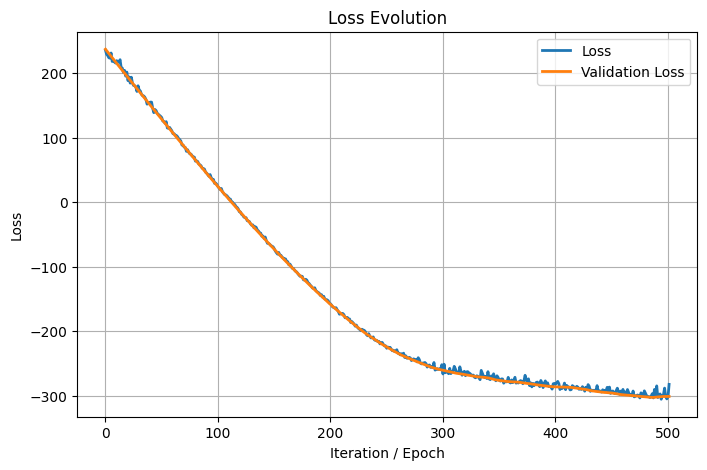

In [11]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.5488e+00,  1.2501e+00,  1.2696e+00,  1.2016e+00,  1.2427e+00,
         1.9503e+00,  1.4231e+00,  3.7471e-01,  9.3499e-01,  3.7231e+00,
         1.6411e+00,  1.6411e+00, -9.3081e+00,  1.2449e+00,  1.1346e+00,
         1.2802e+00,  1.1698e+00,  1.5148e+00,  1.3201e+00,  9.9374e-01,
         2.5499e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00, -1.3960e-02,
         3.5491e-02,  4.9996e-02, -5.9825e-02,  1.0525e-01, -1.2127e-01,
         1.2807e-01, -5.1189e-02,  6.9308e-02, -1.8873e-02,  2.6844e-02,
        -3.0306e-01, -1.3807e-01, -2.6232e-03,  2.1843e-01,  4.0233e-01,
         1.6232e-01, -7.8316e-02,  8.9284e-02, -3.6377e-02, -3.4604e-01,
         5.5611e-01,  5.0786e-01,  2.9570e-01,  2.9596e-01,  3.3270e-01,
         1.2325e-01,  1.7015e-01,  7.3108e-02, -2.1208e-01, -2.1686e-01,
        -2.1287e-01,  7.0472e-02,  7.6340e-02, -1.6801e-01, -2.8240e-01,
        -2.6133e-01, -1.6709e-01, -8.6513e-02, -6.1943e-02,  8.6553e-03,
         9.1538e-03,  1.1136e-01,  1.7529e-

In [13]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [14]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [15]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [16]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [18]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.0523
KLD Gaussian Train Data:  0.1109
KLD Copula   Train Data:  -0.0001
KLD GTM      Test  Data:  1.0628
KLD Gaussian Test  Data:  0.1077
KLD Copula   Test  Data:  0.0046


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [19]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

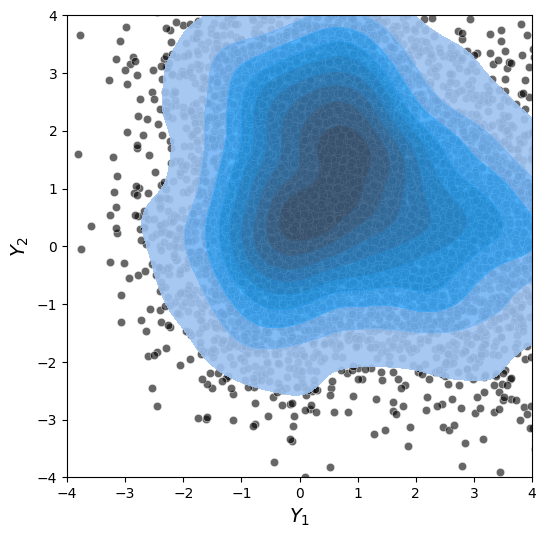

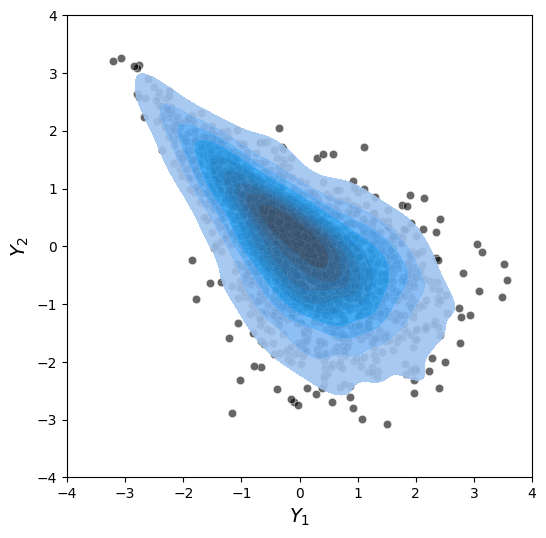

In [20]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [21]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


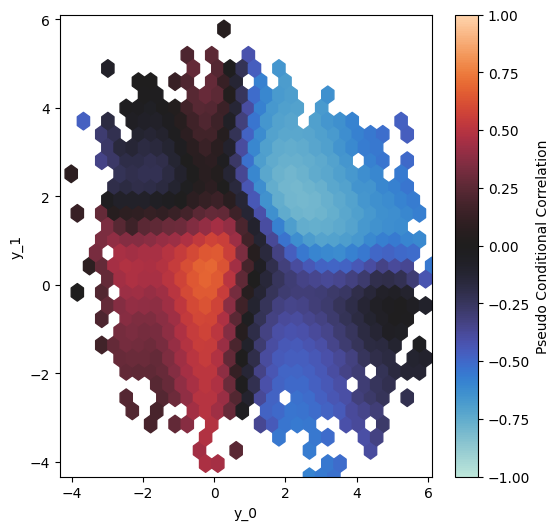

In [22]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


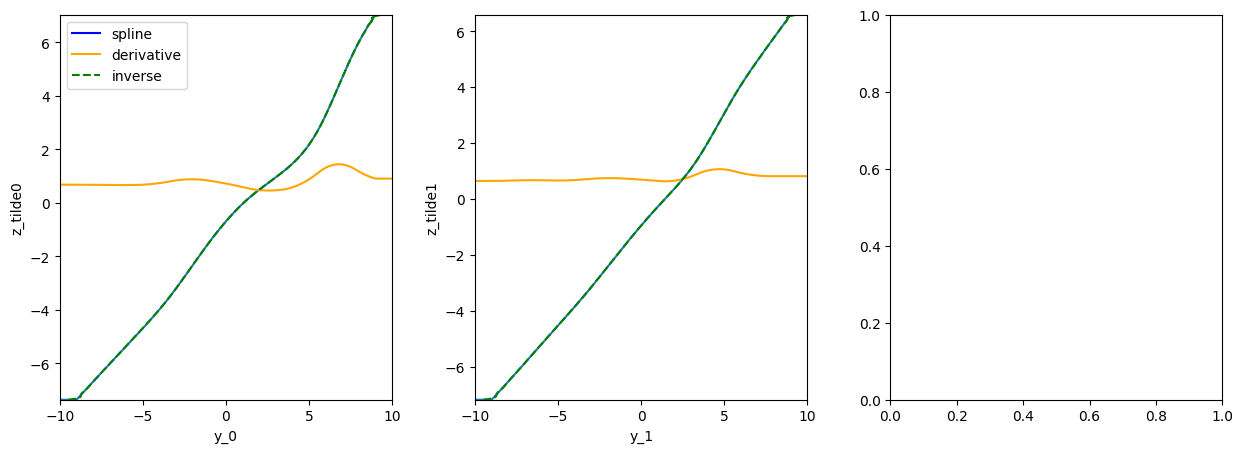

In [23]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


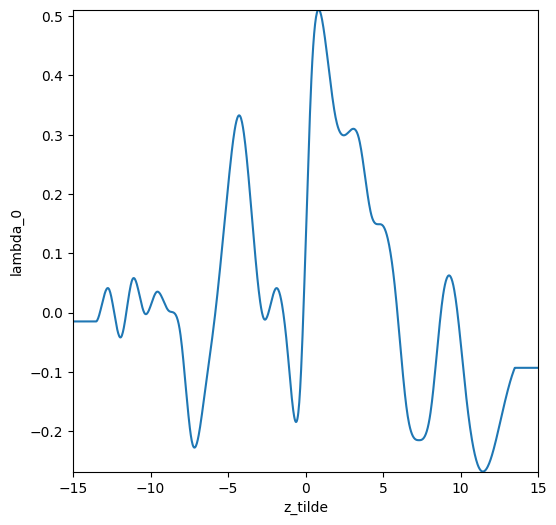

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


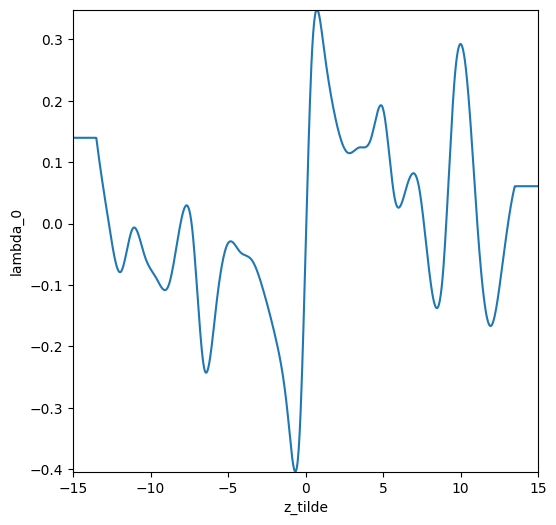

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


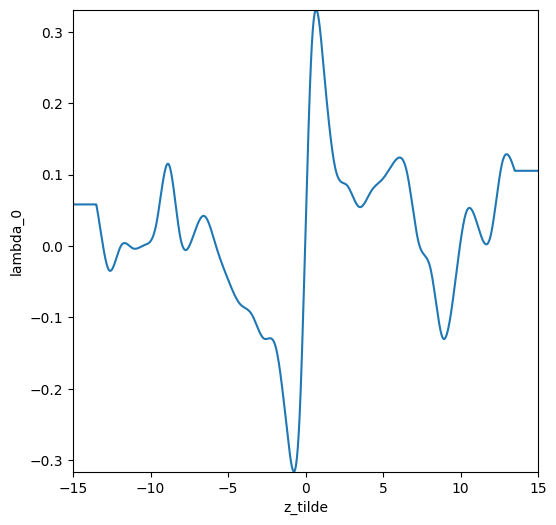

In [26]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)